# Medical Segmentation Decathlon: Ingestion & Normalization

MSD Task06_Lung: 63 training CT scans with lung tumor segmentation masks (~8.5GB). [Dataset reference](https://medicaldecathlon.com/)

**Workflow:**
1. Ingest raw NIfTIs (CT images + segmentation masks)
2. Transform with `map()` (resample to uniform spacing)
3. Write normalized collections (ML-ready)

In [1]:
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from radiobject import (
    RadiObject,
    S3Config,
    SliceOrientation,
    TileConfig,
    WriteConfig,
    configure,
    delete_tiledb_uri,
    uri_exists,
)
from radiobject.data import S3_REGION, get_msd_lung_uri

# Define URIs for raw and normalized data
MSD_LUNG_URI = get_msd_lung_uri()
MSD_LUNG_RAW_URI = MSD_LUNG_URI.replace("radiobject-2mm", "radiobject-raw").replace(
    "msd-lung-tutorial", "msd-lung-raw"
)

print(f"Raw URI: {MSD_LUNG_RAW_URI}")
print(f"Normalized URI: {MSD_LUNG_URI}")

Raw URI: s3://souzy-scratch/msd-lung/radiobject-raw
Normalized URI: s3://souzy-scratch/msd-lung/radiobject-2mm


In [2]:
# Configure S3 access and tile layout
if MSD_LUNG_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION, max_parallel_ops=8))
configure(write=WriteConfig(tile=TileConfig(orientation=SliceOrientation.ISOTROPIC)))

# Data paths
S3_NIFTI_URI = "s3://souzy-scratch/msd-lung/nifti"
DATA_DIR = Path("../data/msd_lung/Task06_Lung")
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Local data: {DATA_DIR.resolve()}")
print(f"Target: {MSD_LUNG_URI}")

Local data: /Users/samueldsouza/Desktop/Code/RadiObject/data/msd_lung/Task06_Lung
Target: s3://souzy-scratch/msd-lung/radiobject-2mm


In [3]:
# Force re-ingestion: Set to True to delete existing data and re-ingest
FORCE_REINGEST = False

if FORCE_REINGEST:
    print("Force re-ingestion enabled. Deleting existing data...")
    delete_tiledb_uri(MSD_LUNG_RAW_URI)
    delete_tiledb_uri(MSD_LUNG_URI)

SKIP_RAW_INGESTION = uri_exists(MSD_LUNG_RAW_URI) and not FORCE_REINGEST
SKIP_NORMALIZATION = uri_exists(MSD_LUNG_URI) and not FORCE_REINGEST

print(f"Skip raw ingestion: {SKIP_RAW_INGESTION}")
print(f"Skip normalization: {SKIP_NORMALIZATION}")

Skip raw ingestion: True
Skip normalization: True


In [4]:
if not SKIP_RAW_INGESTION and not (DATA_DIR / "imagesTr").exists():
    print(f"Downloading from {S3_NIFTI_URI}...")
    result = subprocess.run(
        ["aws", "s3", "sync", S3_NIFTI_URI, str(DATA_DIR)],
        capture_output=True,
        text=True,
    )
    if result.returncode != 0:
        raise RuntimeError(f"Download failed: {result.stderr}")
    print("Download complete.")
elif not SKIP_RAW_INGESTION:
    print(f"Data exists at {DATA_DIR}")

## Ingest CT and Segmentation Collections

Ingest both CT images and segmentation masks as separate collections in a single RadiObject using the `images` dict API.

In [5]:
if not SKIP_RAW_INGESTION:
    # Ingest CT images AND segmentation masks in a single call
    radi_raw = RadiObject.from_niftis(
        uri=MSD_LUNG_RAW_URI,
        images={
            "CT": DATA_DIR / "imagesTr",
            "seg": DATA_DIR / "labelsTr",
        },
        validate_alignment=True,  # Ensure CT and seg have matching subjects
    )
    print(f"\nCreated raw RadiObject: {radi_raw}")
    print(f"CT collection shape: {radi_raw.CT.shape}")
    print(f"seg collection shape: {radi_raw.seg.shape}")
elif uri_exists(MSD_LUNG_RAW_URI):
    radi_raw = RadiObject(MSD_LUNG_RAW_URI)
    print(f"Loaded existing raw: {radi_raw}")
    print(f"Collections: {radi_raw.collection_names}")
else:
    radi_raw = None
    print("Raw data not available - will skip transform step")

Loaded existing raw: RadiObject(63 subjects, 2 collections: [seg, CT])
Collections: ('seg', 'CT')


## Transform with `map()`

Resample both CT and segmentation to 2mm isotropic spacing using `map()`. Each transform
receives `(volume, obs)` — the volume array and its obs metadata row — so zoom factors
are derived directly from `obs["voxel_spacing"]`. Linear interpolation for CT, nearest-neighbor
for segmentation masks.

**Why pre-resample?** RadiObject's `PATCH` loading mode reads sub-volumes directly from TileDB
via partial reads. Applying MONAI `Spacingd` at train time would require full-volume S3 reads
first, negating the key I/O benefit. Pre-resampling trades storage for per-epoch speed.
For small local datasets, train-time resampling via MONAI transforms is simpler.

In [ ]:
from scipy.ndimage import zoom

TARGET_SPACING_MM = 2.0


def resample(order):
    """Resample to isotropic spacing using per-subject voxel spacing from obs metadata."""

    def fn(volume, obs):
        spacing = eval(obs["voxel_spacing"])
        factors = tuple(s / TARGET_SPACING_MM for s in spacing)
        return zoom(volume, factors, order=order)

    return fn


if radi_raw is not None and not SKIP_NORMALIZATION:
    ct_vc = radi_raw.CT.map(resample(order=1)).write(f"{MSD_LUNG_URI}/collections/CT", name="CT")
    seg_vc = radi_raw.seg.map(resample(order=0)).write(
        f"{MSD_LUNG_URI}/collections/seg", name="seg"
    )

    radi = RadiObject.from_collections(
        uri=MSD_LUNG_URI,
        collections={"CT": ct_vc, "seg": seg_vc},
    )
    print(f"Created normalized RadiObject: {radi}")
else:
    print(f"Skipping - normalized data already exists at {MSD_LUNG_URI}")

## Verify Normalized Data

In [7]:
# Load the normalized RadiObject
radi = RadiObject(MSD_LUNG_URI)

print(f"Subjects: {len(radi)}")
print(f"Collections: {radi.collection_names}")
print(f"CT shape: {radi.CT.shape}")
print(f"seg shape: {radi.seg.shape}")

Subjects: 63


Collections: ('CT', 'seg')
CT shape: None
seg shape: None


In [8]:
# Verify CT/seg spatial alignment: CT tissue should exist at tumor locations
subject_id = list(radi.obs_subject_ids)[0]
ct_vol = radi.loc[subject_id].CT.iloc[0]
seg_vol = radi.loc[subject_id].seg.iloc[0]

ct_data = ct_vol.to_numpy()
seg_data = seg_vol.to_numpy()

assert (
    ct_data.shape == seg_data.shape
), f"Shape mismatch: CT {ct_data.shape} vs seg {seg_data.shape}"

tumor_mask = seg_data > 0
ct_at_tumor = ct_data[tumor_mask]
print(
    f"CT at tumor locations: mean={ct_at_tumor.mean():.0f} HU, "
    f"range=[{ct_at_tumor.min():.0f}, {ct_at_tumor.max():.0f}]"
)
assert ct_at_tumor.mean() > -900, "CT at tumor locations is air -- data misaligned!"
print("CT/seg alignment check passed.")

CT at tumor locations: mean=-165 HU, range=[-740, 83]
CT/seg alignment check passed.


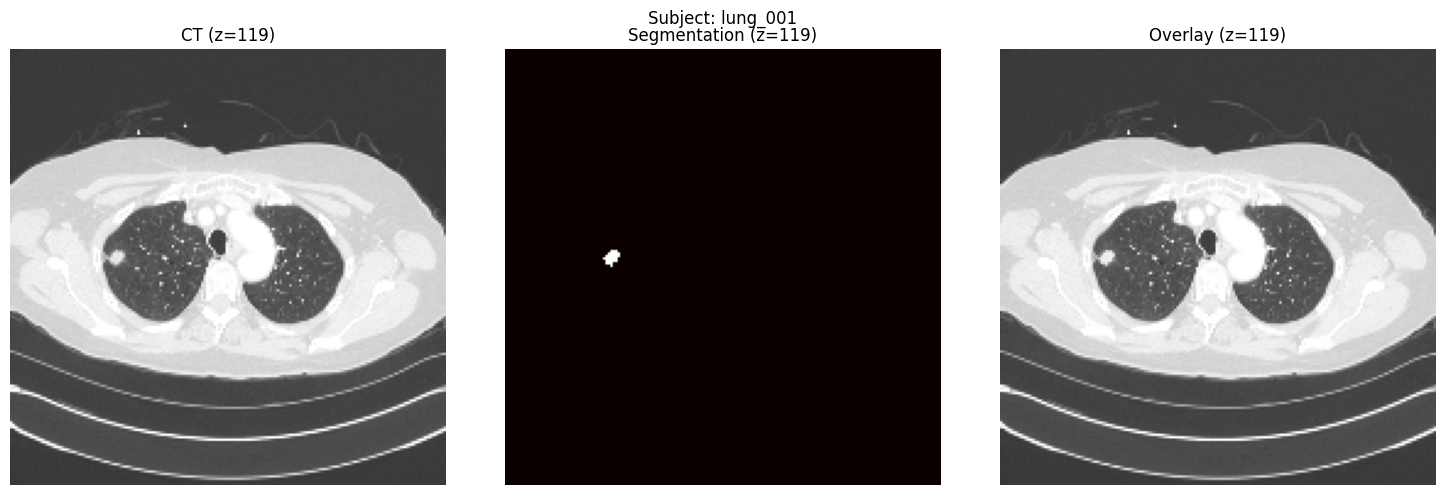

In [9]:
# Visualize CT and segmentation overlay
# (reuses subject_id, ct_vol, seg_vol, seg_data from verification cell)

# Find slice with tumor
tumor_slices = np.where(seg_data.sum(axis=(0, 1)) > 0)[0]
if len(tumor_slices) > 0:
    mid_z = tumor_slices[len(tumor_slices) // 2]
else:
    mid_z = seg_data.shape[2] // 2

ct_slice = ct_vol.axial(z=mid_z).T

# Standard CT lung window (W=1500, L=-600 -> range -1350 to 150 HU)
ct_vmin, ct_vmax = -1350, 150

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CT
axes[0].imshow(ct_slice, cmap="gray", origin="lower", vmin=ct_vmin, vmax=ct_vmax)
axes[0].set_title(f"CT (z={mid_z})")
axes[0].axis("off")

# Segmentation
axes[1].imshow(seg_vol.axial(z=mid_z).T, cmap="hot", origin="lower")
axes[1].set_title(f"Segmentation (z={mid_z})")
axes[1].axis("off")

# Overlay
axes[2].imshow(ct_slice, cmap="gray", origin="lower", vmin=ct_vmin, vmax=ct_vmax)
mask = seg_vol.axial(z=mid_z).T > 0
axes[2].imshow(np.ma.masked_where(~mask, mask), cmap="Reds", alpha=0.5, origin="lower")
axes[2].set_title(f"Overlay (z={mid_z})")
axes[2].axis("off")

plt.suptitle(f"Subject: {subject_id}")
plt.tight_layout()
plt.show()

**Next:** [06_ml_training.ipynb](./06_ml_training.ipynb) - Train a segmentation model using this data.